<a href="https://colab.research.google.com/github/Sarinda251/CAP_5415/blob/main/CVQ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [304]:
import numpy as np
import cv2 as cv
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from scipy.signal import convolve2d
from google.colab.patches import cv2_imshow
import math

#Sigma = .6

##Image 1

In [305]:
# Read Image
I = cv.imread('train1.jpg', 0)
rows,cols = I.shape

# Sigma Value Chosen
sigma = .6

# Filters are created
G = gaussian_filter1d(np.float_([0,1,0]), sigma)
Gx = gaussian_filter1d(np.float_([0,1,0]), sigma, order=1)
Gx.shape = (1,3)
Gy = Gx.transpose()

# Convolve with mask
Ix = convolve1d(I,G,0)
Iy = convolve1d(I,G,1)
IxP = convolve2d(Ix,Gx,'same')
IyP = convolve2d(Iy,Gy,'same')

# Calculated Magnitide
Mag0 = IxP**2 + IyP**2
Mag = np.sqrt(Mag0)

# Non-maximal Suppression
gradient = np.vectorize(math.atan2)
Grad = gradient(IyP,IxP)
Supp = np.ndarray((rows,cols))

for i in range(1,rows - 1):
  for j in range(1,cols - 1):
    # keep angles in [-pi/2, pi/2)
    if Grad[i,j] >= (math.pi) / 2:
      Grad[i,j] = Grad[i,j] - math.pi
    elif Grad[i,j] < (math.pi) / -2:
      Grad[i,j] = Grad[i,j] + math.pi

    # the suppression array is initially a clone of the original array
    Supp[i,j] = Mag[i,j]
    
    # compare against the 2 points to determine if suppression is needed
    # based on the angle (handled by if/elses) the points for comparison are determined
    # and their magnitudes are calculated based on neighboring points
    # if the center point is not greater than both, its magnitude is set to 0
    if abs(Grad[i,j] - (math.pi) / -2) < .1 :
      p1 = Mag[i-1, j]
      p2 = Mag[i+1, j]
      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (-1 * math.pi) / 4:
      x1 = i - 1
      y1 = j - math.tan((math.pi/-2) - Grad[i,j])
      x2 = i + 1
      y2 = j + math.tan((math.pi/-2) - Grad[i,j])

      slope1 = Mag[i-1, j+1] - Mag[i-1, j]
      slope2 = Mag[i+1, j-1] - Mag[i+1, j]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i-1, j]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i+1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (0 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i-1, j+1] - Mag[i, j+1]
      slope2 = Mag[i+1, j-1] - Mag[i-1, j]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i-1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (1 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (2 * math.pi) / 4:
      x1 = i - math.tan((math.pi/2) - Grad[i,j])
      y1 = j - 1
      x2 = i + math.tan((math.pi/2) - Grad[i,j])
      y2 = j + 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0

# Set high and low threshold
highThreshold = 21
lowThreshold = 15

M, N = Supp.shape
out = np.zeros((M,N), dtype= np.uint8)

# If edge intensity is greater than high thresh it is strong
# below low threshold, it is a not an edge
strong_i, strong_j = np.where(Supp >= highThreshold)
zeros_i, zeros_j = np.where(Supp < lowThreshold)

# weak edges
weak_i, weak_j = np.where((Supp <= highThreshold) & (Supp >= lowThreshold))

# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

# checks if weak edges are near strong edges or not to determine end strength
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

###Output Images

I


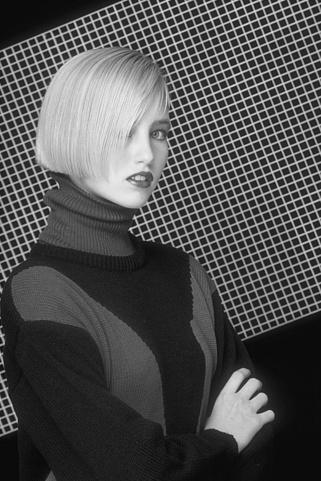

Ix


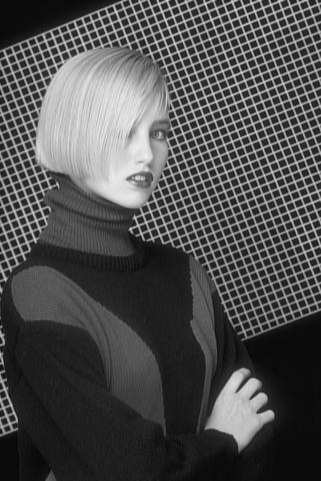

Iy


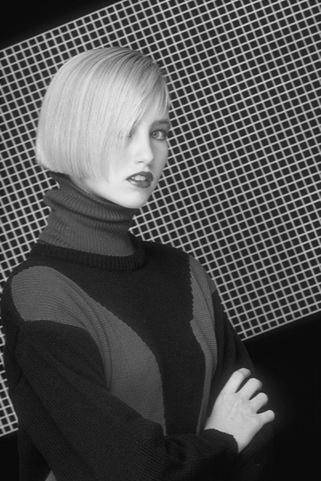

Ix'


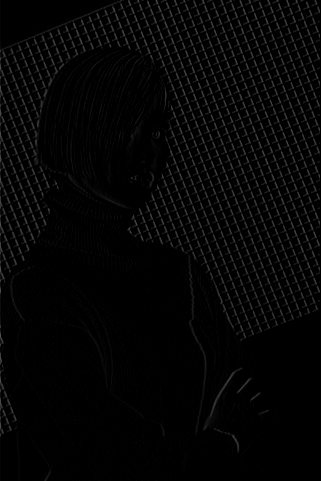

Iy'


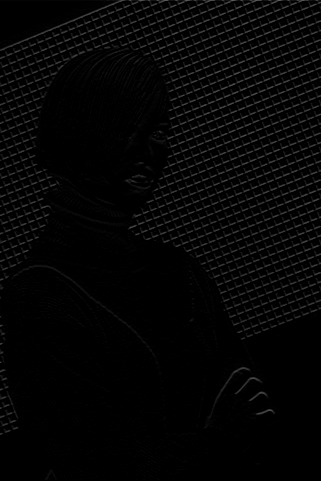

Magnitude


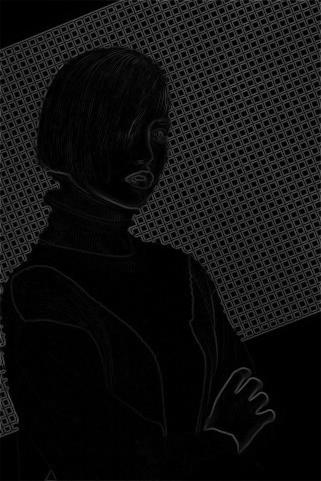

Non-Max Suppression


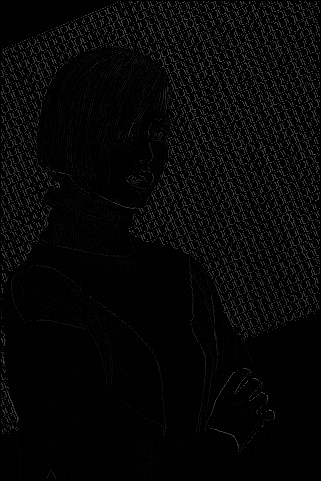

Hysteresis Thresholding


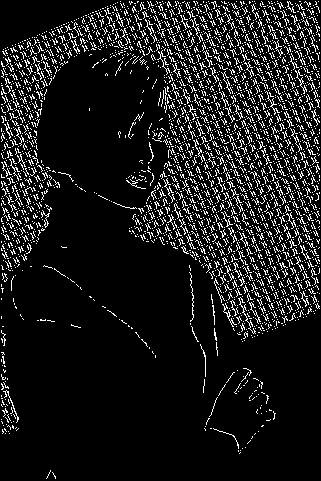

In [306]:
#output images
print("I")
cv2_imshow(I)
print("Ix")
cv2_imshow(Ix)
print("Iy")
cv2_imshow(Iy)
print("Ix\'")
cv2_imshow(IxP)
print("Iy\'")
cv2_imshow(IyP)
print("Magnitude")
cv2_imshow(Mag)
print("Non-Max Suppression")
cv2_imshow(Supp)
print("Hysteresis Thresholding")
cv2_imshow(out)

##Image 2

In [307]:
# Read Image
I = cv.imread('train2.jpg', 0)
rows,cols = I.shape

# Sigma Value Chosen
sigma = .6

# Filters are created
G = gaussian_filter1d(np.float_([0,1,0]), sigma)
Gx = gaussian_filter1d(np.float_([0,1,0]), sigma, order=1)
Gx.shape = (1,3)
Gy = Gx.transpose()

# Convolve with mask
Ix = convolve1d(I,G,0)
Iy = convolve1d(I,G,1)
IxP = convolve2d(Ix,Gx,'same')
IyP = convolve2d(Iy,Gy,'same')

# Calculated Magnitide
Mag0 = IxP**2 + IyP**2
Mag = np.sqrt(Mag0)

# Non-maximal Suppression
gradient = np.vectorize(math.atan2)
Grad = gradient(IyP,IxP)
Supp = np.ndarray((rows,cols))

for i in range(1,rows - 1):
  for j in range(1,cols - 1):
    # keep angles in [-pi/2, pi/2)
    if Grad[i,j] >= (math.pi) / 2:
      Grad[i,j] = Grad[i,j] - math.pi
    elif Grad[i,j] < (math.pi) / -2:
      Grad[i,j] = Grad[i,j] + math.pi

    # the suppression array is initially a clone of the original array
    Supp[i,j] = Mag[i,j]
    
    # compare against the 2 points to determine if suppression is needed
    # based on the angle (handled by if/elses) the points for comparison are determined
    # and their magnitudes are calculated based on neighboring points
    # if the center point is not greater than both, its magnitude is set to 0
    if abs(Grad[i,j] - (math.pi) / -2) < .1 :
      p1 = Mag[i-1, j]
      p2 = Mag[i+1, j]
      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (-1 * math.pi) / 4:
      x1 = i - 1
      y1 = j - math.tan((math.pi/-2) - Grad[i,j])
      x2 = i + 1
      y2 = j + math.tan((math.pi/-2) - Grad[i,j])

      slope1 = Mag[i-1, j+1] - Mag[i-1, j]
      slope2 = Mag[i+1, j-1] - Mag[i+1, j]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i-1, j]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i+1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (0 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i-1, j+1] - Mag[i, j+1]
      slope2 = Mag[i+1, j-1] - Mag[i-1, j]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i-1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (1 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (2 * math.pi) / 4:
      x1 = i - math.tan((math.pi/2) - Grad[i,j])
      y1 = j - 1
      x2 = i + math.tan((math.pi/2) - Grad[i,j])
      y2 = j + 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0

# Set high and low threshold
highThreshold = 21
lowThreshold = 15

M, N = Supp.shape
out = np.zeros((M,N), dtype= np.uint8)

# If edge intensity is greater than high thresh it is strong
# below low threshold, it is a not an edge
strong_i, strong_j = np.where(Supp >= highThreshold)
zeros_i, zeros_j = np.where(Supp < lowThreshold)

# weak edges
weak_i, weak_j = np.where((Supp <= highThreshold) & (Supp >= lowThreshold))

# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

# checks if weak edges are near strong edges or not to determine end strength
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

###Output Images

I


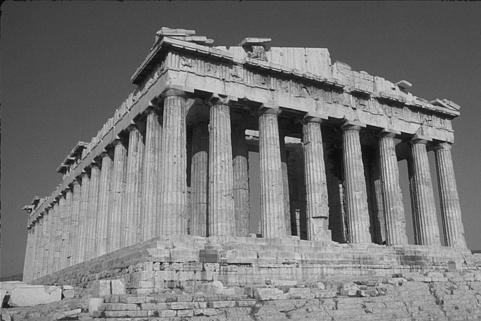

Ix


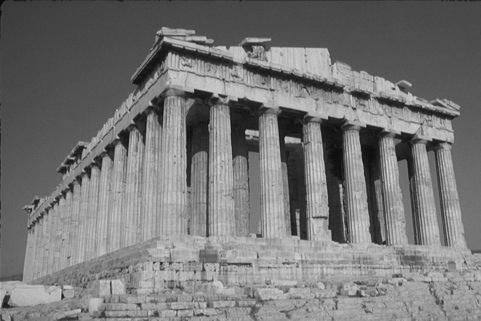

Iy


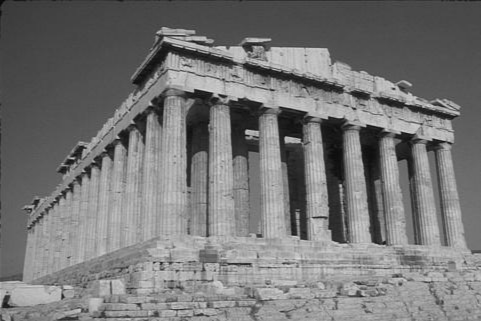

Ix'


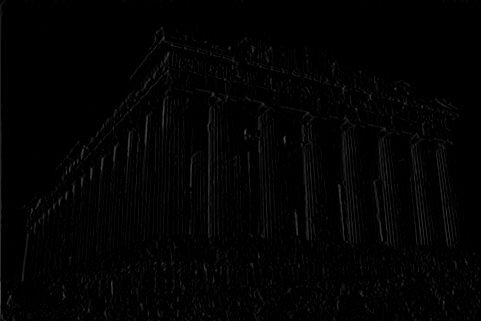

Iy'


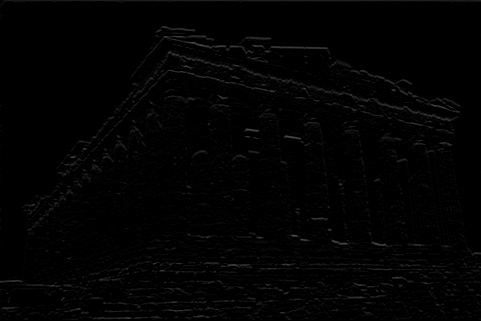

Magnitude


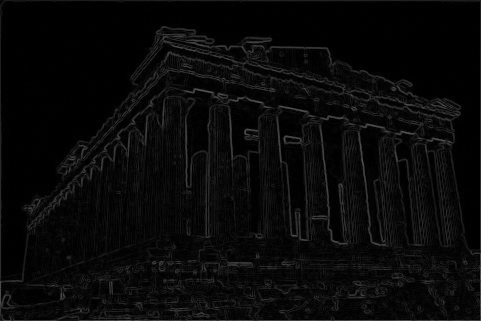

Non-Max Suppression


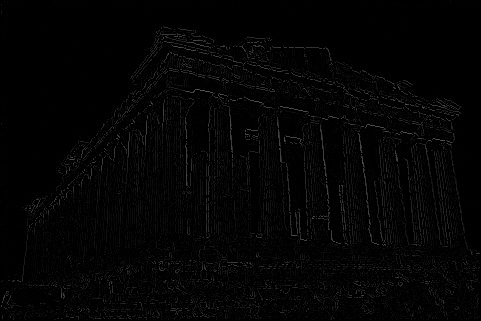

Hysteresis Thresholding


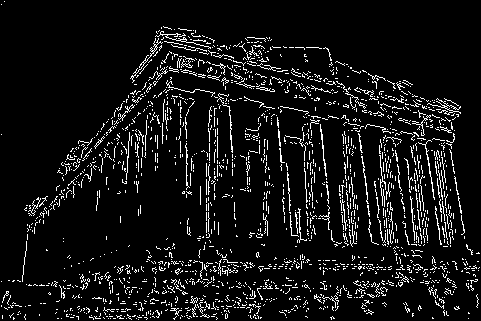

In [308]:
#output images
print("I")
cv2_imshow(I)
print("Ix")
cv2_imshow(Ix)
print("Iy")
cv2_imshow(Iy)
print("Ix\'")
cv2_imshow(IxP)
print("Iy\'")
cv2_imshow(IyP)
print("Magnitude")
cv2_imshow(Mag)
print("Non-Max Suppression")
cv2_imshow(Supp)
print("Hysteresis Thresholding")
cv2_imshow(out)

##Image 3

In [309]:
# Read Image
I = cv.imread('train3.jpg', 0)
rows,cols = I.shape

# Sigma Value Chosen
sigma = .6

# Filters are created
G = gaussian_filter1d(np.float_([0,1,0]), sigma)
Gx = gaussian_filter1d(np.float_([0,1,0]), sigma, order=1)
Gx.shape = (1,3)
Gy = Gx.transpose()

# Convolve with mask
Ix = convolve1d(I,G,0)
Iy = convolve1d(I,G,1)
IxP = convolve2d(Ix,Gx,'same')
IyP = convolve2d(Iy,Gy,'same')

# Calculated Magnitide
Mag0 = IxP**2 + IyP**2
Mag = np.sqrt(Mag0)

# Non-maximal Suppression
gradient = np.vectorize(math.atan2)
Grad = gradient(IyP,IxP)
Supp = np.ndarray((rows,cols))

for i in range(1,rows - 1):
  for j in range(1,cols - 1):
    # keep angles in [-pi/2, pi/2)
    if Grad[i,j] >= (math.pi) / 2:
      Grad[i,j] = Grad[i,j] - math.pi
    elif Grad[i,j] < (math.pi) / -2:
      Grad[i,j] = Grad[i,j] + math.pi

    # the suppression array is initially a clone of the original array
    Supp[i,j] = Mag[i,j]
    
    # compare against the 2 points to determine if suppression is needed
    # based on the angle (handled by if/elses) the points for comparison are determined
    # and their magnitudes are calculated based on neighboring points
    # if the center point is not greater than both, its magnitude is set to 0
    if abs(Grad[i,j] - (math.pi) / -2) < .1 :
      p1 = Mag[i-1, j]
      p2 = Mag[i+1, j]
      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (-1 * math.pi) / 4:
      x1 = i - 1
      y1 = j - math.tan((math.pi/-2) - Grad[i,j])
      x2 = i + 1
      y2 = j + math.tan((math.pi/-2) - Grad[i,j])

      slope1 = Mag[i-1, j+1] - Mag[i-1, j]
      slope2 = Mag[i+1, j-1] - Mag[i+1, j]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i-1, j]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i+1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (0 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i-1, j+1] - Mag[i, j+1]
      slope2 = Mag[i+1, j-1] - Mag[i-1, j]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i-1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (1 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (2 * math.pi) / 4:
      x1 = i - math.tan((math.pi/2) - Grad[i,j])
      y1 = j - 1
      x2 = i + math.tan((math.pi/2) - Grad[i,j])
      y2 = j + 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0

# Set high and low threshold
highThreshold = 31
lowThreshold = 15

M, N = Supp.shape
out = np.zeros((M,N), dtype= np.uint8)

# If edge intensity is greater than high thresh it is strong
# below low threshold, it is a not an edge
strong_i, strong_j = np.where(Supp >= highThreshold)
zeros_i, zeros_j = np.where(Supp < lowThreshold)

# weak edges
weak_i, weak_j = np.where((Supp <= highThreshold) & (Supp >= lowThreshold))

# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

# checks if weak edges are near strong edges or not to determine end strength
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

###Output Images

I


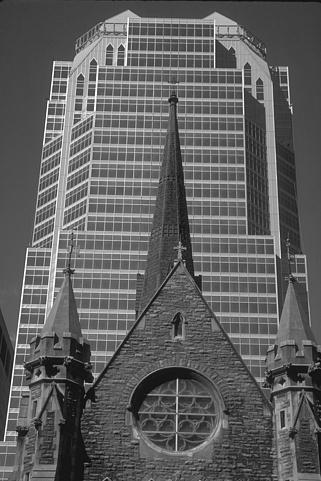

Ix


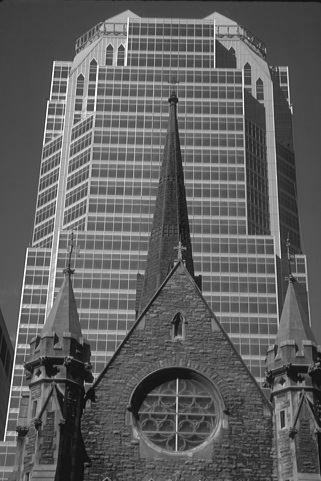

Iy


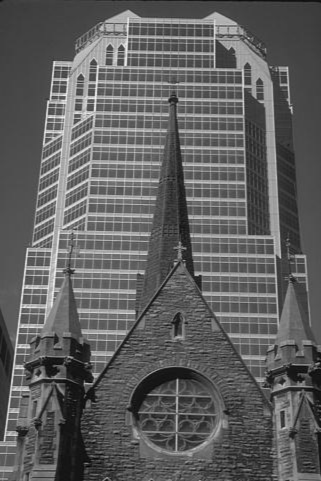

Ix'


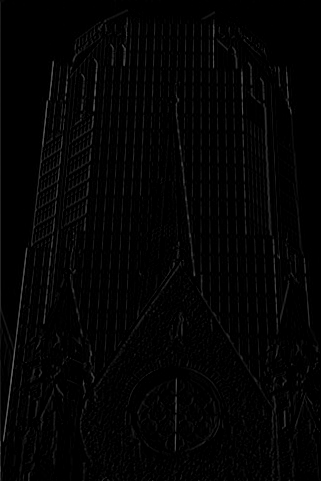

Iy'


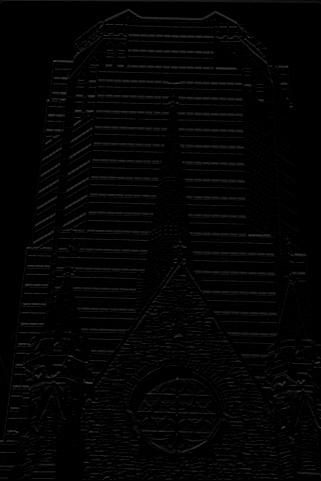

Magnitude


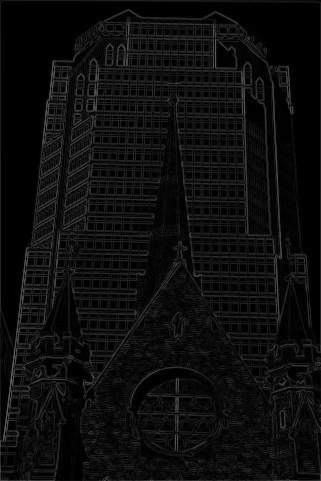

Non-Max Suppression


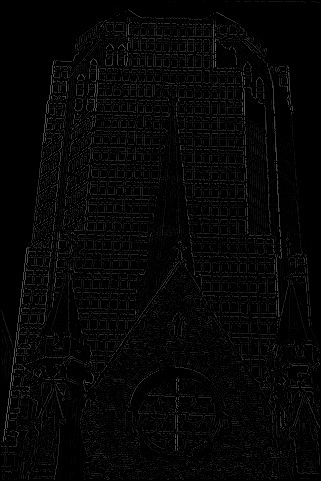

Hysteresis Thresholding


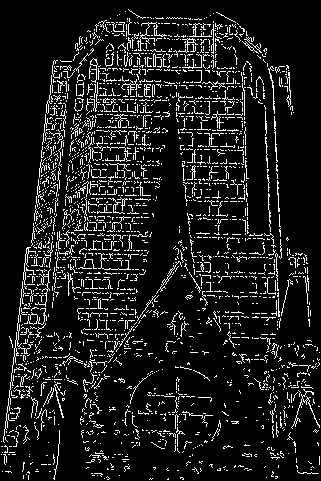

In [310]:
#output images
print("I")
cv2_imshow(I)
print("Ix")
cv2_imshow(Ix)
print("Iy")
cv2_imshow(Iy)
print("Ix\'")
cv2_imshow(IxP)
print("Iy\'")
cv2_imshow(IyP)
print("Magnitude")
cv2_imshow(Mag)
print("Non-Max Suppression")
cv2_imshow(Supp)
print("Hysteresis Thresholding")
cv2_imshow(out)

#Sigma = .4

##Image 1

In [311]:
# Read Image
I = cv.imread('train1.jpg', 0)
rows,cols = I.shape

# Sigma Value Chosen
sigma = .4

# Filters are created
G = gaussian_filter1d(np.float_([0,1,0]), sigma)
Gx = gaussian_filter1d(np.float_([0,1,0]), sigma, order=1)
Gx.shape = (1,3)
Gy = Gx.transpose()

# Convolve with mask
Ix = convolve1d(I,G,0)
Iy = convolve1d(I,G,1)
IxP = convolve2d(Ix,Gx,'same')
IyP = convolve2d(Iy,Gy,'same')

# Calculated Magnitide
Mag0 = IxP**2 + IyP**2
Mag = np.sqrt(Mag0)

# Non-maximal Suppression
gradient = np.vectorize(math.atan2)
Grad = gradient(IyP,IxP)
Supp = np.ndarray((rows,cols))

for i in range(1,rows - 1):
  for j in range(1,cols - 1):
    # keep angles in [-pi/2, pi/2)
    if Grad[i,j] >= (math.pi) / 2:
      Grad[i,j] = Grad[i,j] - math.pi
    elif Grad[i,j] < (math.pi) / -2:
      Grad[i,j] = Grad[i,j] + math.pi

    # the suppression array is initially a clone of the original array
    Supp[i,j] = Mag[i,j]
    
    # compare against the 2 points to determine if suppression is needed
    # based on the angle (handled by if/elses) the points for comparison are determined
    # and their magnitudes are calculated based on neighboring points
    # if the center point is not greater than both, its magnitude is set to 0
    if abs(Grad[i,j] - (math.pi) / -2) < .1 :
      p1 = Mag[i-1, j]
      p2 = Mag[i+1, j]
      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (-1 * math.pi) / 4:
      x1 = i - 1
      y1 = j - math.tan((math.pi/-2) - Grad[i,j])
      x2 = i + 1
      y2 = j + math.tan((math.pi/-2) - Grad[i,j])

      slope1 = Mag[i-1, j+1] - Mag[i-1, j]
      slope2 = Mag[i+1, j-1] - Mag[i+1, j]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i-1, j]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i+1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (0 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i-1, j+1] - Mag[i, j+1]
      slope2 = Mag[i+1, j-1] - Mag[i-1, j]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i-1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (1 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (2 * math.pi) / 4:
      x1 = i - math.tan((math.pi/2) - Grad[i,j])
      y1 = j - 1
      x2 = i + math.tan((math.pi/2) - Grad[i,j])
      y2 = j + 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0

# Set high and low threshold
highThreshold = 21
lowThreshold = 15

M, N = Supp.shape
out = np.zeros((M,N), dtype= np.uint8)

# If edge intensity is greater than high thresh it is strong
# below low threshold, it is a not an edge
strong_i, strong_j = np.where(Supp >= highThreshold)
zeros_i, zeros_j = np.where(Supp < lowThreshold)

# weak edges
weak_i, weak_j = np.where((Supp <= highThreshold) & (Supp >= lowThreshold))

# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

# checks if weak edges are near strong edges or not to determine end strength
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

###Output Images

I


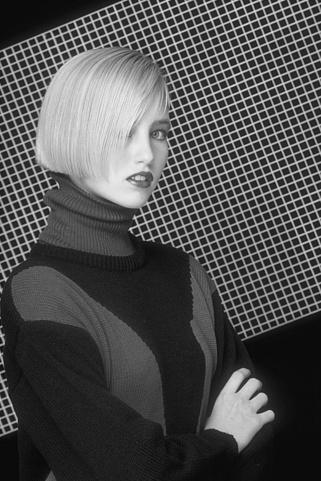

Ix


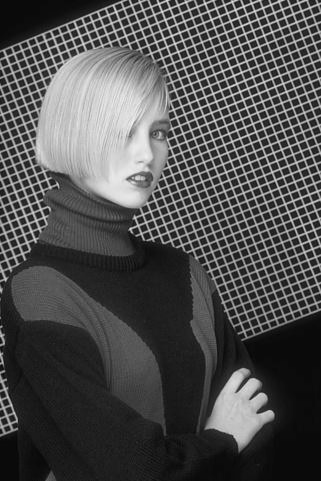

Iy


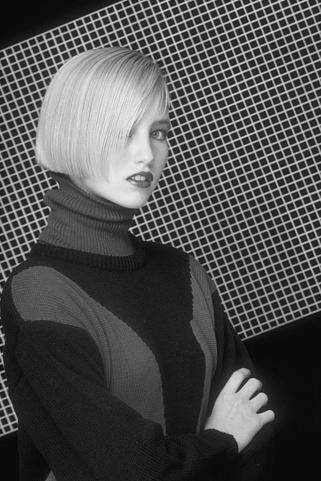

Ix'


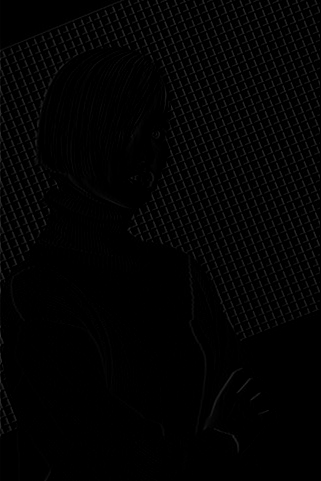

Iy'


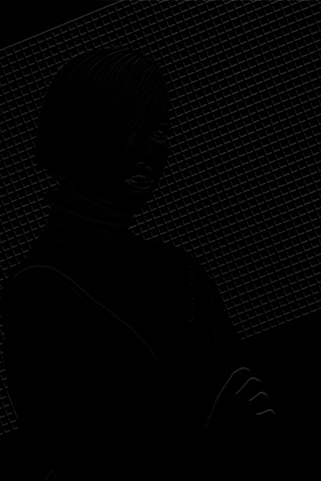

Magnitude


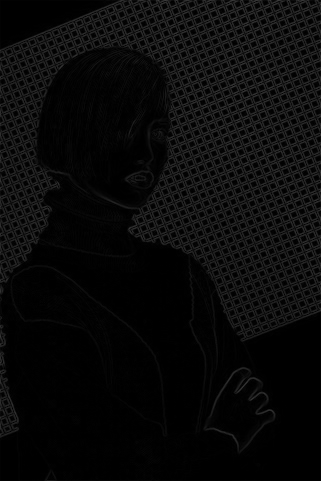

Non-Max Suppression


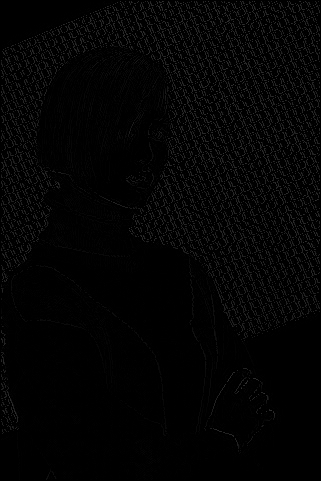

Hysteresis Thresholding


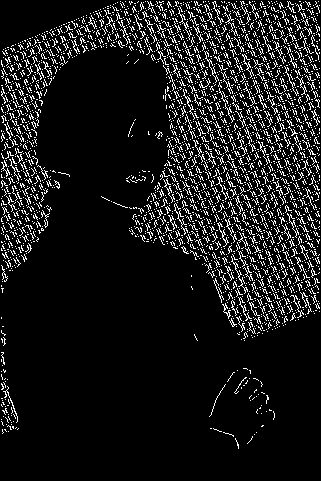

In [312]:
#output images
print("I")
cv2_imshow(I)
print("Ix")
cv2_imshow(Ix)
print("Iy")
cv2_imshow(Iy)
print("Ix\'")
cv2_imshow(IxP)
print("Iy\'")
cv2_imshow(IyP)
print("Magnitude")
cv2_imshow(Mag)
print("Non-Max Suppression")
cv2_imshow(Supp)
print("Hysteresis Thresholding")
cv2_imshow(out)

##Image 2

In [313]:
# Read Image
I = cv.imread('train2.jpg', 0)
rows,cols = I.shape

# Sigma Value Chosen
sigma = .4

# Filters are created
G = gaussian_filter1d(np.float_([0,1,0]), sigma)
Gx = gaussian_filter1d(np.float_([0,1,0]), sigma, order=1)
Gx.shape = (1,3)
Gy = Gx.transpose()

# Convolve with mask
Ix = convolve1d(I,G,0)
Iy = convolve1d(I,G,1)
IxP = convolve2d(Ix,Gx,'same')
IyP = convolve2d(Iy,Gy,'same')

# Calculated Magnitide
Mag0 = IxP**2 + IyP**2
Mag = np.sqrt(Mag0)

# Non-maximal Suppression
gradient = np.vectorize(math.atan2)
Grad = gradient(IyP,IxP)
Supp = np.ndarray((rows,cols))

for i in range(1,rows - 1):
  for j in range(1,cols - 1):
    # keep angles in [-pi/2, pi/2)
    if Grad[i,j] >= (math.pi) / 2:
      Grad[i,j] = Grad[i,j] - math.pi
    elif Grad[i,j] < (math.pi) / -2:
      Grad[i,j] = Grad[i,j] + math.pi

    # the suppression array is initially a clone of the original array
    Supp[i,j] = Mag[i,j]
    
    # compare against the 2 points to determine if suppression is needed
    # based on the angle (handled by if/elses) the points for comparison are determined
    # and their magnitudes are calculated based on neighboring points
    # if the center point is not greater than both, its magnitude is set to 0
    if abs(Grad[i,j] - (math.pi) / -2) < .1 :
      p1 = Mag[i-1, j]
      p2 = Mag[i+1, j]
      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (-1 * math.pi) / 4:
      x1 = i - 1
      y1 = j - math.tan((math.pi/-2) - Grad[i,j])
      x2 = i + 1
      y2 = j + math.tan((math.pi/-2) - Grad[i,j])

      slope1 = Mag[i-1, j+1] - Mag[i-1, j]
      slope2 = Mag[i+1, j-1] - Mag[i+1, j]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i-1, j]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i+1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (0 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i-1, j+1] - Mag[i, j+1]
      slope2 = Mag[i+1, j-1] - Mag[i-1, j]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i-1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (1 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (2 * math.pi) / 4:
      x1 = i - math.tan((math.pi/2) - Grad[i,j])
      y1 = j - 1
      x2 = i + math.tan((math.pi/2) - Grad[i,j])
      y2 = j + 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0

# Set high and low threshold
highThreshold = 21
lowThreshold = 15

M, N = Supp.shape
out = np.zeros((M,N), dtype= np.uint8)

# If edge intensity is greater than high thresh it is strong
# below low threshold, it is a not an edge
strong_i, strong_j = np.where(Supp >= highThreshold)
zeros_i, zeros_j = np.where(Supp < lowThreshold)

# weak edges
weak_i, weak_j = np.where((Supp <= highThreshold) & (Supp >= lowThreshold))

# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

# checks if weak edges are near strong edges or not to determine end strength
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

###Output Images

I


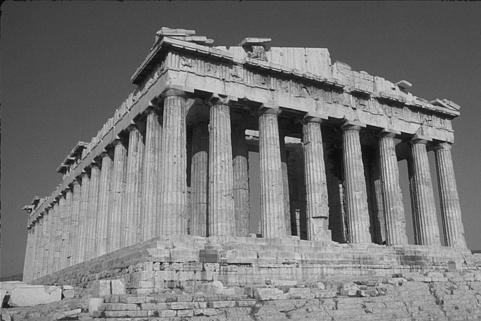

Ix


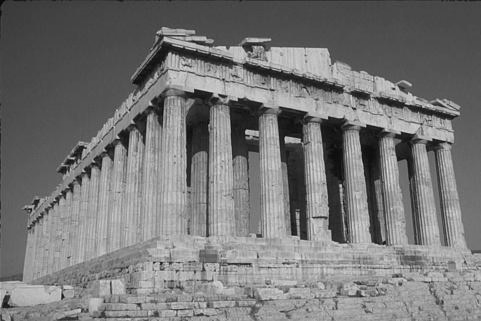

Iy


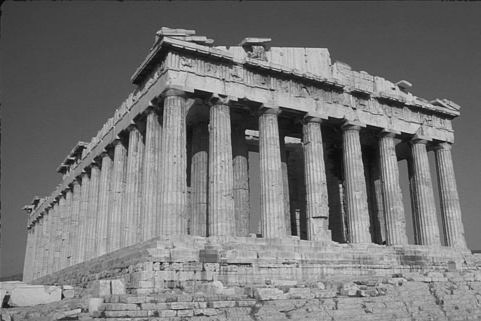

Ix'


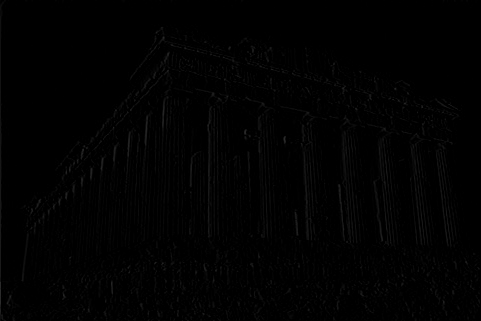

Iy'


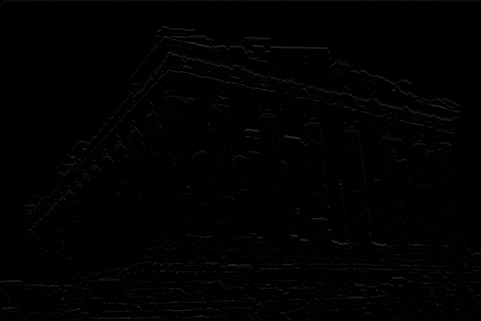

Magnitude


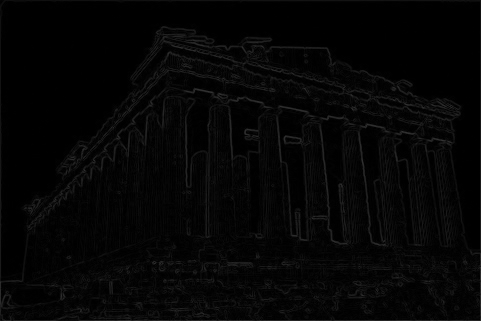

Non-Max Suppression


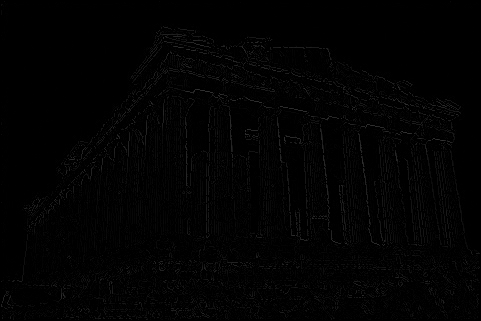

Hysteresis Thresholding


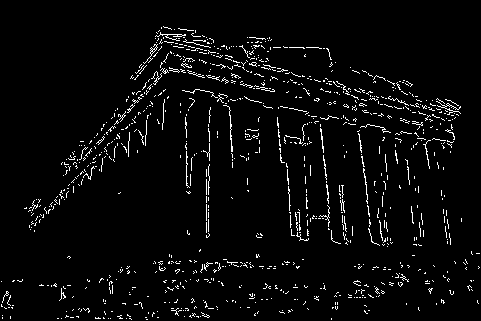

In [314]:
#output images
print("I")
cv2_imshow(I)
print("Ix")
cv2_imshow(Ix)
print("Iy")
cv2_imshow(Iy)
print("Ix\'")
cv2_imshow(IxP)
print("Iy\'")
cv2_imshow(IyP)
print("Magnitude")
cv2_imshow(Mag)
print("Non-Max Suppression")
cv2_imshow(Supp)
print("Hysteresis Thresholding")
cv2_imshow(out)

##Image 3

In [315]:
# Read Image
I = cv.imread('train3.jpg', 0)
rows,cols = I.shape

# Sigma Value Chosen
sigma = .4

# Filters are created
G = gaussian_filter1d(np.float_([0,1,0]), sigma)
Gx = gaussian_filter1d(np.float_([0,1,0]), sigma, order=1)
Gx.shape = (1,3)
Gy = Gx.transpose()

# Convolve with mask
Ix = convolve1d(I,G,0)
Iy = convolve1d(I,G,1)
IxP = convolve2d(Ix,Gx,'same')
IyP = convolve2d(Iy,Gy,'same')

# Calculated Magnitide
Mag0 = IxP**2 + IyP**2
Mag = np.sqrt(Mag0)

# Non-maximal Suppression
gradient = np.vectorize(math.atan2)
Grad = gradient(IyP,IxP)
Supp = np.ndarray((rows,cols))

for i in range(1,rows - 1):
  for j in range(1,cols - 1):
    # keep angles in [-pi/2, pi/2)
    if Grad[i,j] >= (math.pi) / 2:
      Grad[i,j] = Grad[i,j] - math.pi
    elif Grad[i,j] < (math.pi) / -2:
      Grad[i,j] = Grad[i,j] + math.pi

    # the suppression array is initially a clone of the original array
    Supp[i,j] = Mag[i,j]
    
    # compare against the 2 points to determine if suppression is needed
    # based on the angle (handled by if/elses) the points for comparison are determined
    # and their magnitudes are calculated based on neighboring points
    # if the center point is not greater than both, its magnitude is set to 0
    if abs(Grad[i,j] - (math.pi) / -2) < .1 :
      p1 = Mag[i-1, j]
      p2 = Mag[i+1, j]
      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (-1 * math.pi) / 4:
      x1 = i - 1
      y1 = j - math.tan((math.pi/-2) - Grad[i,j])
      x2 = i + 1
      y2 = j + math.tan((math.pi/-2) - Grad[i,j])

      slope1 = Mag[i-1, j+1] - Mag[i-1, j]
      slope2 = Mag[i+1, j-1] - Mag[i+1, j]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i-1, j]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i+1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (0 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i-1, j+1] - Mag[i, j+1]
      slope2 = Mag[i+1, j-1] - Mag[i-1, j]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i-1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (1 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (2 * math.pi) / 4:
      x1 = i - math.tan((math.pi/2) - Grad[i,j])
      y1 = j - 1
      x2 = i + math.tan((math.pi/2) - Grad[i,j])
      y2 = j + 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0

# Set high and low threshold
highThreshold = 21
lowThreshold = 15

M, N = Supp.shape
out = np.zeros((M,N), dtype= np.uint8)

# If edge intensity is greater than high thresh it is strong
# below low threshold, it is a not an edge
strong_i, strong_j = np.where(Supp >= highThreshold)
zeros_i, zeros_j = np.where(Supp < lowThreshold)

# weak edges
weak_i, weak_j = np.where((Supp <= highThreshold) & (Supp >= lowThreshold))

# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

# checks if weak edges are near strong edges or not to determine end strength
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

###Output Images

I


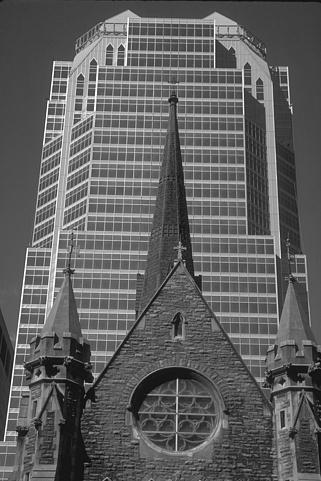

Ix


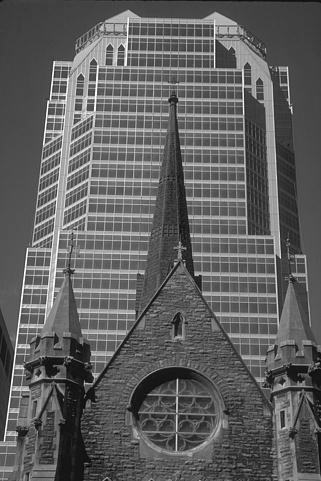

Iy


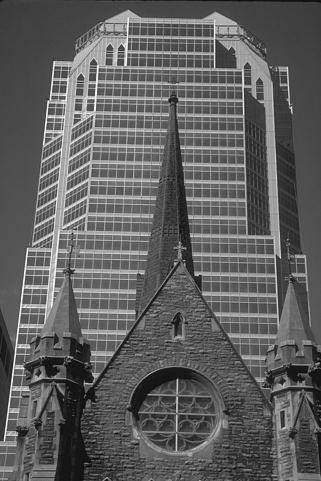

Ix'


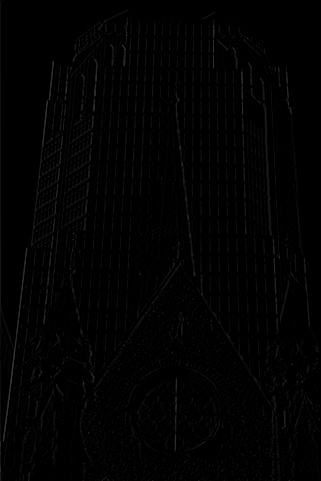

Iy'


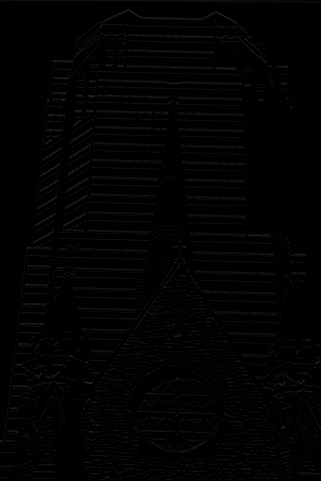

Magnitude


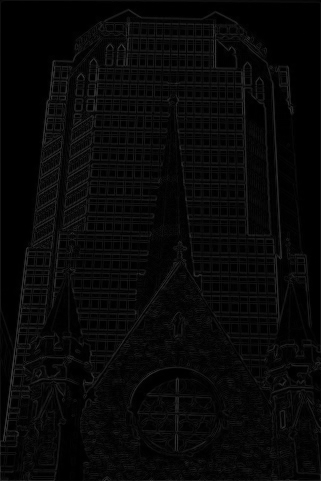

Non-Max Suppression


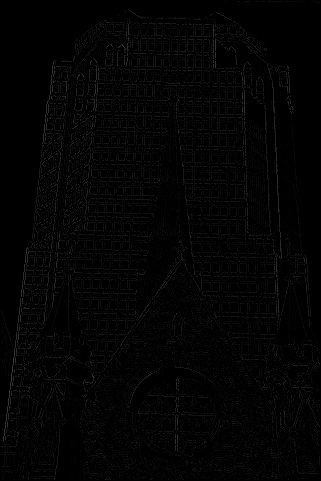

Hysteresis Thresholding


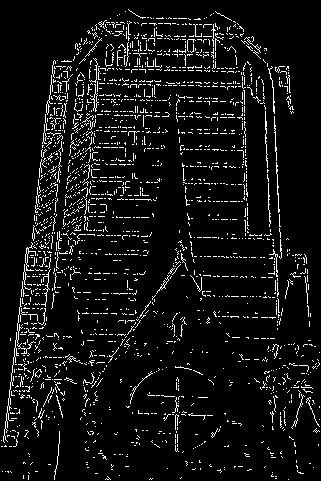

In [316]:
#output images
print("I")
cv2_imshow(I)
print("Ix")
cv2_imshow(Ix)
print("Iy")
cv2_imshow(Iy)
print("Ix\'")
cv2_imshow(IxP)
print("Iy\'")
cv2_imshow(IyP)
print("Magnitude")
cv2_imshow(Mag)
print("Non-Max Suppression")
cv2_imshow(Supp)
print("Hysteresis Thresholding")
cv2_imshow(out)

#Sigma = .8

##Image 1

In [317]:
# Read Image
I = cv.imread('train1.jpg', 0)
rows,cols = I.shape

# Sigma Value Chosen
sigma = .8

# Filters are created
G = gaussian_filter1d(np.float_([0,1,0]), sigma)
Gx = gaussian_filter1d(np.float_([0,1,0]), sigma, order=1)
Gx.shape = (1,3)
Gy = Gx.transpose()

# Convolve with mask
Ix = convolve1d(I,G,0)
Iy = convolve1d(I,G,1)
IxP = convolve2d(Ix,Gx,'same')
IyP = convolve2d(Iy,Gy,'same')

# Calculated Magnitide
Mag0 = IxP**2 + IyP**2
Mag = np.sqrt(Mag0)

# Non-maximal Suppression
gradient = np.vectorize(math.atan2)
Grad = gradient(IyP,IxP)
Supp = np.ndarray((rows,cols))

for i in range(1,rows - 1):
  for j in range(1,cols - 1):
    # keep angles in [-pi/2, pi/2)
    if Grad[i,j] >= (math.pi) / 2:
      Grad[i,j] = Grad[i,j] - math.pi
    elif Grad[i,j] < (math.pi) / -2:
      Grad[i,j] = Grad[i,j] + math.pi

    # the suppression array is initially a clone of the original array
    Supp[i,j] = Mag[i,j]
    
    # compare against the 2 points to determine if suppression is needed
    # based on the angle (handled by if/elses) the points for comparison are determined
    # and their magnitudes are calculated based on neighboring points
    # if the center point is not greater than both, its magnitude is set to 0
    if abs(Grad[i,j] - (math.pi) / -2) < .1 :
      p1 = Mag[i-1, j]
      p2 = Mag[i+1, j]
      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (-1 * math.pi) / 4:
      x1 = i - 1
      y1 = j - math.tan((math.pi/-2) - Grad[i,j])
      x2 = i + 1
      y2 = j + math.tan((math.pi/-2) - Grad[i,j])

      slope1 = Mag[i-1, j+1] - Mag[i-1, j]
      slope2 = Mag[i+1, j-1] - Mag[i+1, j]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i-1, j]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i+1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (0 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i-1, j+1] - Mag[i, j+1]
      slope2 = Mag[i+1, j-1] - Mag[i-1, j]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i-1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (1 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (2 * math.pi) / 4:
      x1 = i - math.tan((math.pi/2) - Grad[i,j])
      y1 = j - 1
      x2 = i + math.tan((math.pi/2) - Grad[i,j])
      y2 = j + 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0

# Set high and low threshold
highThreshold = 21
lowThreshold = 15

M, N = Supp.shape
out = np.zeros((M,N), dtype= np.uint8)

# If edge intensity is greater than high thresh it is strong
# below low threshold, it is a not an edge
strong_i, strong_j = np.where(Supp >= highThreshold)
zeros_i, zeros_j = np.where(Supp < lowThreshold)

# weak edges
weak_i, weak_j = np.where((Supp <= highThreshold) & (Supp >= lowThreshold))

# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

# checks if weak edges are near strong edges or not to determine end strength
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

###Output Images

I


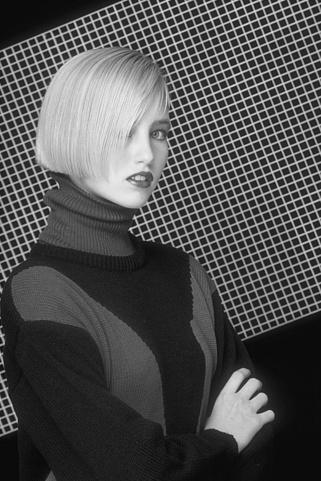

Ix


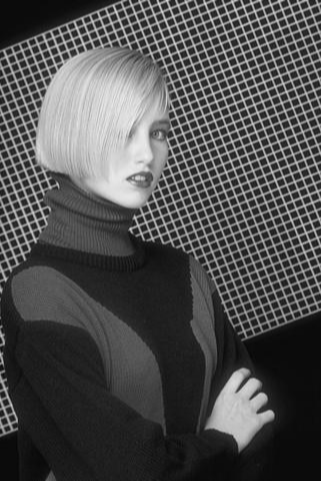

Iy


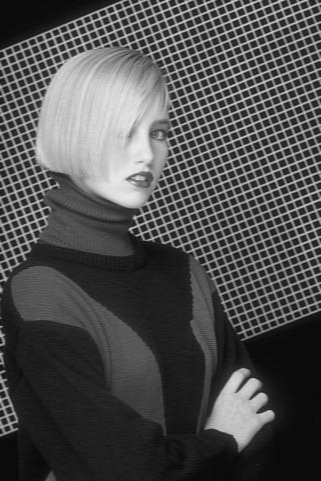

Ix'


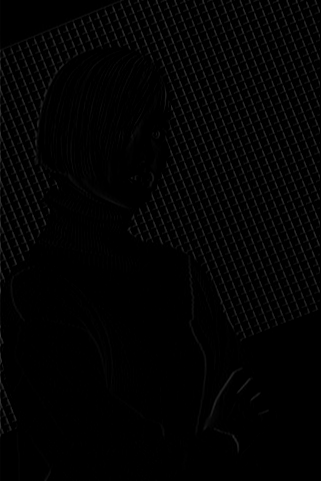

Iy'


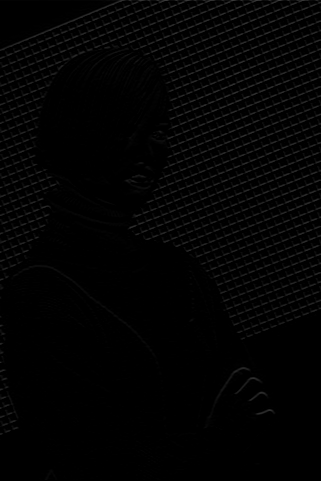

Magnitude


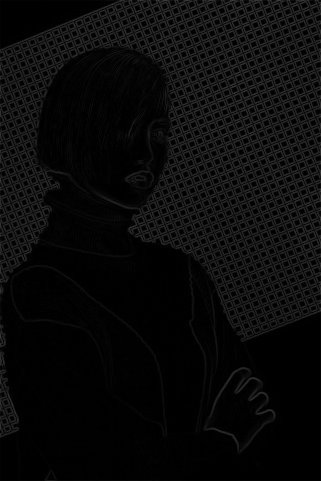

Non-Max Suppression


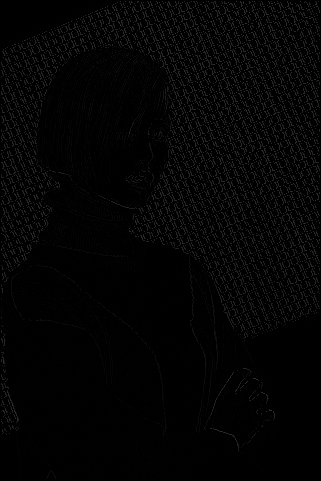

Hysteresis Thresholding


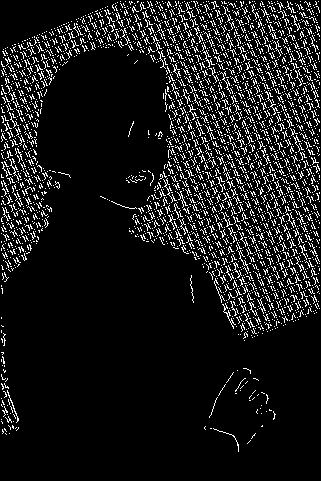

In [318]:
#output images
print("I")
cv2_imshow(I)
print("Ix")
cv2_imshow(Ix)
print("Iy")
cv2_imshow(Iy)
print("Ix\'")
cv2_imshow(IxP)
print("Iy\'")
cv2_imshow(IyP)
print("Magnitude")
cv2_imshow(Mag)
print("Non-Max Suppression")
cv2_imshow(Supp)
print("Hysteresis Thresholding")
cv2_imshow(out)

##Image 2

In [319]:
# Read Image
I = cv.imread('train2.jpg', 0)
rows,cols = I.shape

# Sigma Value Chosen
sigma = .8

# Filters are created
G = gaussian_filter1d(np.float_([0,1,0]), sigma)
Gx = gaussian_filter1d(np.float_([0,1,0]), sigma, order=1)
Gx.shape = (1,3)
Gy = Gx.transpose()

# Convolve with mask
Ix = convolve1d(I,G,0)
Iy = convolve1d(I,G,1)
IxP = convolve2d(Ix,Gx,'same')
IyP = convolve2d(Iy,Gy,'same')

# Calculated Magnitide
Mag0 = IxP**2 + IyP**2
Mag = np.sqrt(Mag0)

# Non-maximal Suppression
gradient = np.vectorize(math.atan2)
Grad = gradient(IyP,IxP)
Supp = np.ndarray((rows,cols))

for i in range(1,rows - 1):
  for j in range(1,cols - 1):
    # keep angles in [-pi/2, pi/2)
    if Grad[i,j] >= (math.pi) / 2:
      Grad[i,j] = Grad[i,j] - math.pi
    elif Grad[i,j] < (math.pi) / -2:
      Grad[i,j] = Grad[i,j] + math.pi

    # the suppression array is initially a clone of the original array
    Supp[i,j] = Mag[i,j]
    
    # compare against the 2 points to determine if suppression is needed
    # based on the angle (handled by if/elses) the points for comparison are determined
    # and their magnitudes are calculated based on neighboring points
    # if the center point is not greater than both, its magnitude is set to 0
    if abs(Grad[i,j] - (math.pi) / -2) < .1 :
      p1 = Mag[i-1, j]
      p2 = Mag[i+1, j]
      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (-1 * math.pi) / 4:
      x1 = i - 1
      y1 = j - math.tan((math.pi/-2) - Grad[i,j])
      x2 = i + 1
      y2 = j + math.tan((math.pi/-2) - Grad[i,j])

      slope1 = Mag[i-1, j+1] - Mag[i-1, j]
      slope2 = Mag[i+1, j-1] - Mag[i+1, j]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i-1, j]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i+1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (0 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i-1, j+1] - Mag[i, j+1]
      slope2 = Mag[i+1, j-1] - Mag[i-1, j]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i-1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (1 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (2 * math.pi) / 4:
      x1 = i - math.tan((math.pi/2) - Grad[i,j])
      y1 = j - 1
      x2 = i + math.tan((math.pi/2) - Grad[i,j])
      y2 = j + 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0

# Set high and low threshold
highThreshold = 21
lowThreshold = 15

M, N = Supp.shape
out = np.zeros((M,N), dtype= np.uint8)

# If edge intensity is greater than high thresh it is strong
# below low threshold, it is a not an edge
strong_i, strong_j = np.where(Supp >= highThreshold)
zeros_i, zeros_j = np.where(Supp < lowThreshold)

# weak edges
weak_i, weak_j = np.where((Supp <= highThreshold) & (Supp >= lowThreshold))

# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

# checks if weak edges are near strong edges or not to determine end strength
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

###Output Images

I


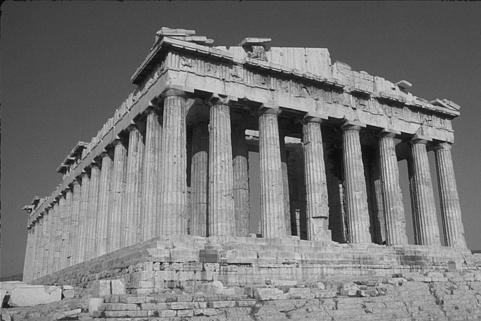

Ix


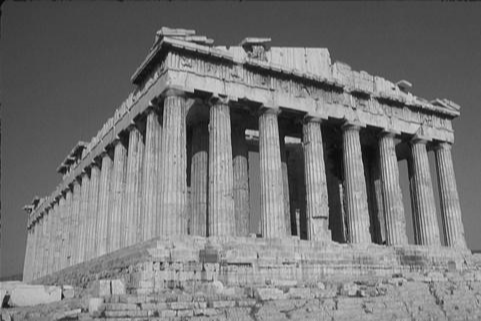

Iy


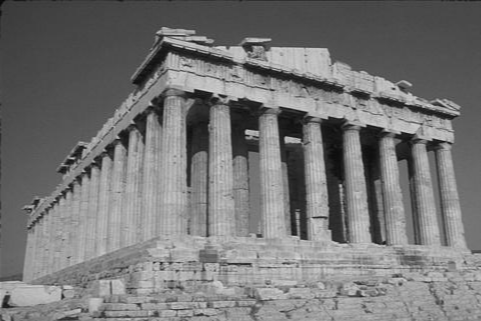

Ix'


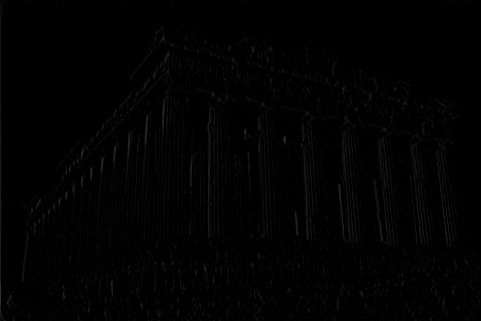

Iy'


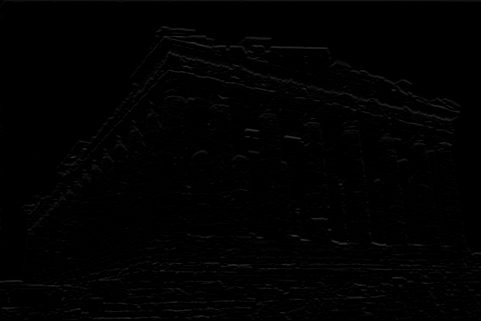

Magnitude


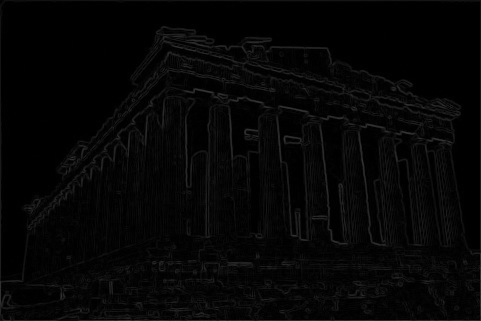

Non-Max Suppression


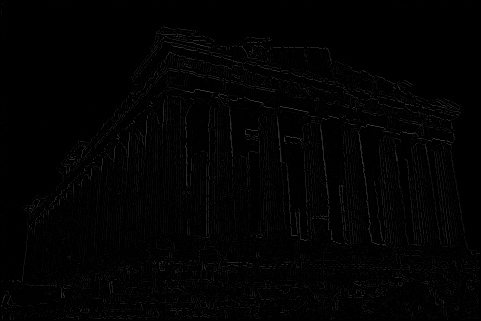

Hysteresis Thresholding


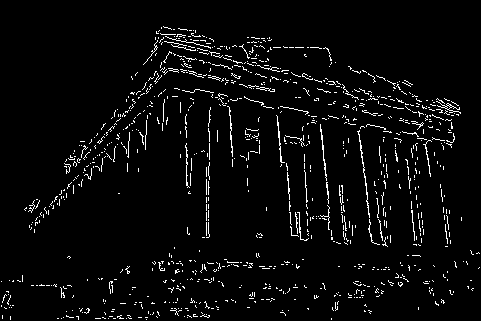

In [320]:
#output images
print("I")
cv2_imshow(I)
print("Ix")
cv2_imshow(Ix)
print("Iy")
cv2_imshow(Iy)
print("Ix\'")
cv2_imshow(IxP)
print("Iy\'")
cv2_imshow(IyP)
print("Magnitude")
cv2_imshow(Mag)
print("Non-Max Suppression")
cv2_imshow(Supp)
print("Hysteresis Thresholding")
cv2_imshow(out)

##Image 3

In [321]:
# Read Image
I = cv.imread('train3.jpg', 0)
rows,cols = I.shape

# Sigma Value Chosen
sigma = .8

# Filters are created
G = gaussian_filter1d(np.float_([0,1,0]), sigma)
Gx = gaussian_filter1d(np.float_([0,1,0]), sigma, order=1)
Gx.shape = (1,3)
Gy = Gx.transpose()

# Convolve with mask
Ix = convolve1d(I,G,0)
Iy = convolve1d(I,G,1)
IxP = convolve2d(Ix,Gx,'same')
IyP = convolve2d(Iy,Gy,'same')

# Calculated Magnitide
Mag0 = IxP**2 + IyP**2
Mag = np.sqrt(Mag0)

# Non-maximal Suppression
gradient = np.vectorize(math.atan2)
Grad = gradient(IyP,IxP)
Supp = np.ndarray((rows,cols))

for i in range(1,rows - 1):
  for j in range(1,cols - 1):
    # keep angles in [-pi/2, pi/2)
    if Grad[i,j] >= (math.pi) / 2:
      Grad[i,j] = Grad[i,j] - math.pi
    elif Grad[i,j] < (math.pi) / -2:
      Grad[i,j] = Grad[i,j] + math.pi

    # the suppression array is initially a clone of the original array
    Supp[i,j] = Mag[i,j]
    
    # compare against the 2 points to determine if suppression is needed
    # based on the angle (handled by if/elses) the points for comparison are determined
    # and their magnitudes are calculated based on neighboring points
    # if the center point is not greater than both, its magnitude is set to 0
    if abs(Grad[i,j] - (math.pi) / -2) < .1 :
      p1 = Mag[i-1, j]
      p2 = Mag[i+1, j]
      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (-1 * math.pi) / 4:
      x1 = i - 1
      y1 = j - math.tan((math.pi/-2) - Grad[i,j])
      x2 = i + 1
      y2 = j + math.tan((math.pi/-2) - Grad[i,j])

      slope1 = Mag[i-1, j+1] - Mag[i-1, j]
      slope2 = Mag[i+1, j-1] - Mag[i+1, j]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i-1, j]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i+1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (0 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i-1, j+1] - Mag[i, j+1]
      slope2 = Mag[i+1, j-1] - Mag[i-1, j]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i-1, j]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (1 * math.pi) / 4:
      x1 = i + math.tan(Grad[i,j])
      y1 = j + 1
      x2 = i - math.tan(Grad[i,j])
      y2 = j - 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * + math.tan(Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * - math.tan(Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0
    elif Grad[i,j] < (2 * math.pi) / 4:
      x1 = i - math.tan((math.pi/2) - Grad[i,j])
      y1 = j - 1
      x2 = i + math.tan((math.pi/2) - Grad[i,j])
      y2 = j + 1

      slope1 = Mag[i+1, j+1] - Mag[i, j+1]
      slope2 = Mag[i-1, j-1] - Mag[i, j-1]
      p1 = slope1 * - math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j+1]
      p2 = slope2 * + math.tan((math.pi/-2) - Grad[i,j]) + Mag[i, j-1]

      if Mag[i,j] <= p1 or Mag[i,j] <= p2:
        Supp[i,j] = 0

# Set high and low threshold
highThreshold = 21
lowThreshold = 15

M, N = Supp.shape
out = np.zeros((M,N), dtype= np.uint8)

# If edge intensity is greater than high thresh it is strong
# below low threshold, it is a not an edge
strong_i, strong_j = np.where(Supp >= highThreshold)
zeros_i, zeros_j = np.where(Supp < lowThreshold)

# weak edges
weak_i, weak_j = np.where((Supp <= highThreshold) & (Supp >= lowThreshold))

# Set same intensity value for all edge pixels
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

# checks if weak edges are near strong edges or not to determine end strength
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

###Output Images

I


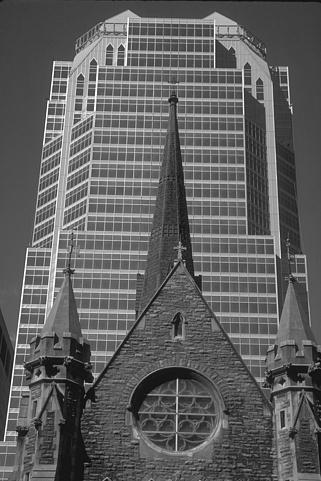

Ix


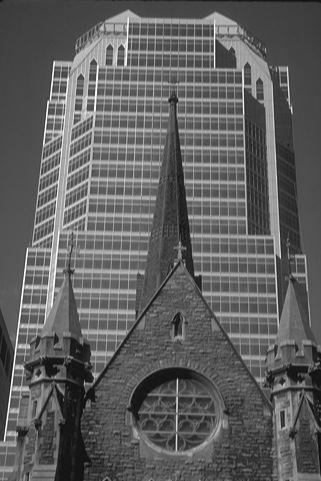

Iy


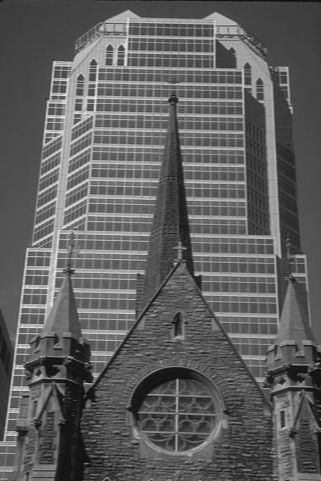

Ix'


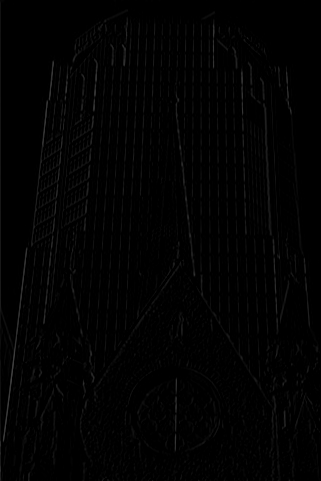

Iy'


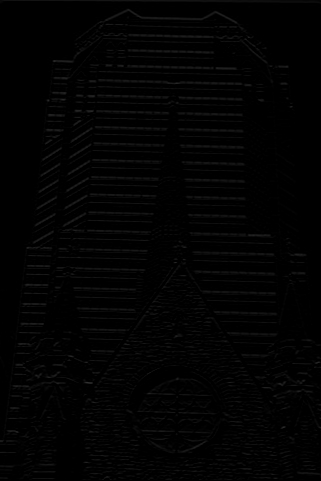

Magnitude


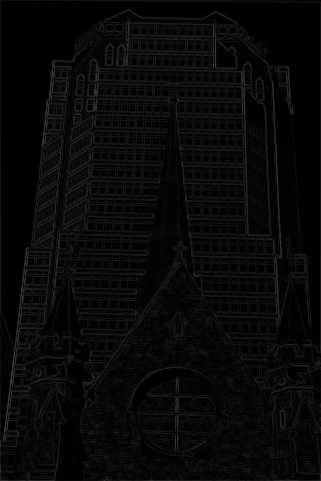

Non-Max Suppression


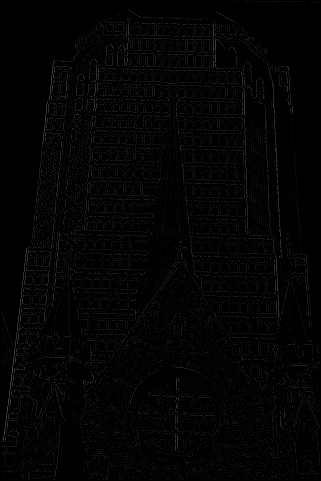

Hysteresis Thresholding


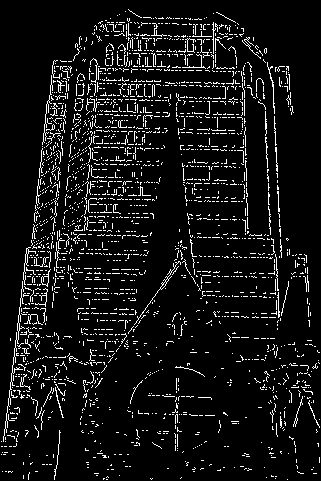

In [322]:
#output images
print("I")
cv2_imshow(I)
print("Ix")
cv2_imshow(Ix)
print("Iy")
cv2_imshow(Iy)
print("Ix\'")
cv2_imshow(IxP)
print("Iy\'")
cv2_imshow(IyP)
print("Magnitude")
cv2_imshow(Mag)
print("Non-Max Suppression")
cv2_imshow(Supp)
print("Hysteresis Thresholding")
cv2_imshow(out)